In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv("dataset_bitcoin_returns (1).csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB
None


,returns
0,-0.098023
1,-0.006172
2,0.134714
3,0.004694
4,0.118912


In [19]:
train_split = int(len(df) - 10)
df_train = df.iloc[:train_split].copy()
df_test = df.iloc[train_split:].copy()
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Train: (990, 1)
Test: (10, 1)


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_series(df, title, xlabel='index', ylabel='returns', rolling_windows=[30]):
    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Returns Series
    axes[0].plot(df.index, df[ylabel], color='blue', linewidth=0.8, alpha=0.7, label=ylabel)
    axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=11)
    axes[0].set_ylabel(ylabel, fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot 2: Rolling Standard Deviations
    # Ensure rolling_windows is a list, even if a single integer is passed
    if not isinstance(rolling_windows, list):
        rolling_windows = [rolling_windows]

    for window in rolling_windows:
        rolling_std_name = f'rolling_std_{window}'
        df[rolling_std_name] = df[ylabel].rolling(window=window).std()
        axes[1].plot(df.index, df[rolling_std_name], linewidth=1.2, label=f'Window={window}')


    axes[1].set_title(f'Rolling Standard Deviation for various windows', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Index', fontsize=11)
    axes[1].set_ylabel('Standard Deviation', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(title='Rolling Window Sizes') # Add a legend for different windows

    plt.tight_layout()
    plt.show()

    # ACF and PACF plots for squared returns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    sq_ret = (df[ylabel].dropna().values)**2 # Drop NA if there are any from rolling calculations
    fig.suptitle(f'Autocorrelation and Partial Autocorrelation Functions of Squared ({ylabel.upper()})', fontsize=16, fontweight='bold')
    plot_acf(sq_ret, lags=20, ax=axes[0])
    plot_pacf(sq_ret, lags=20, ax=axes[1]);
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


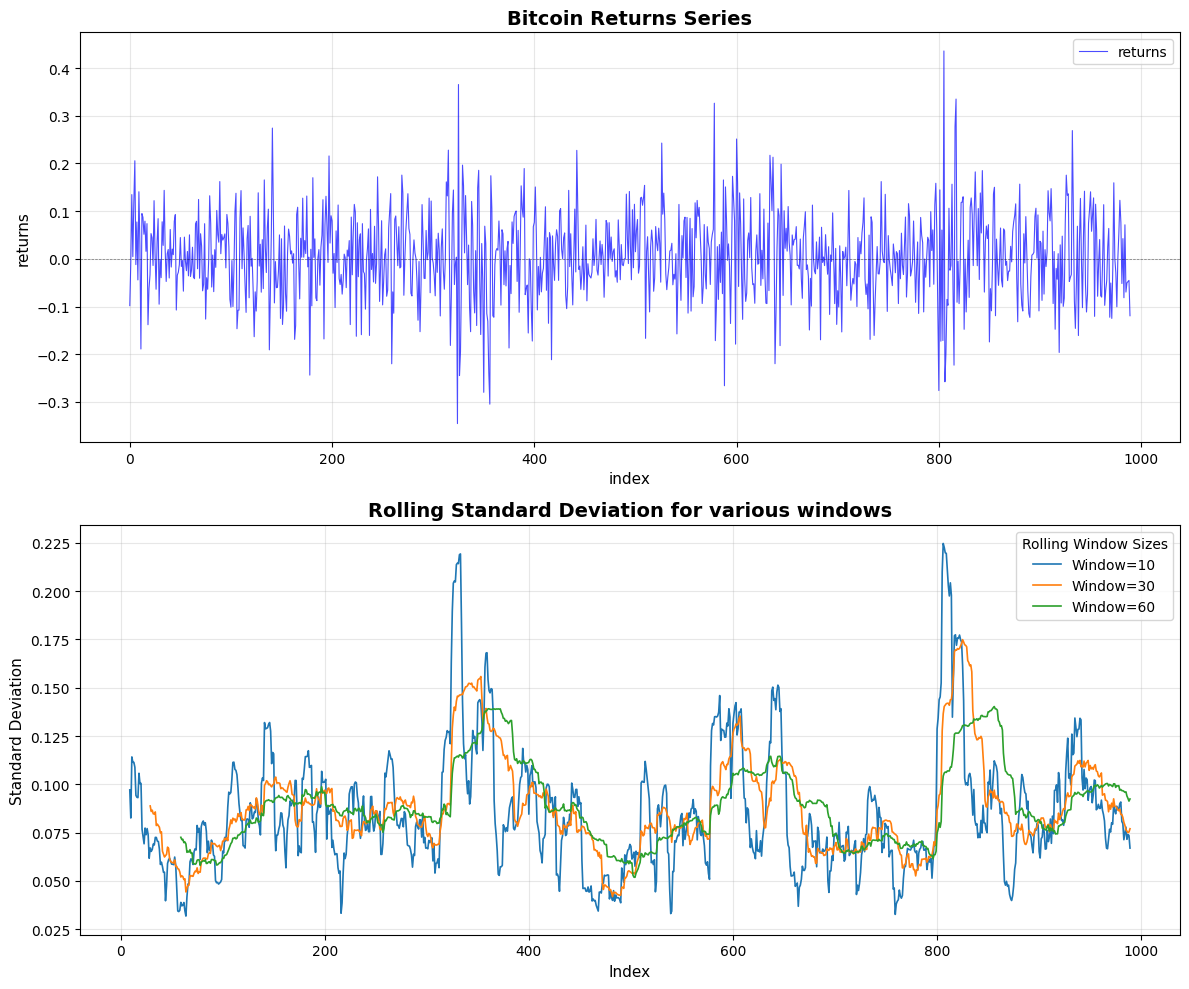

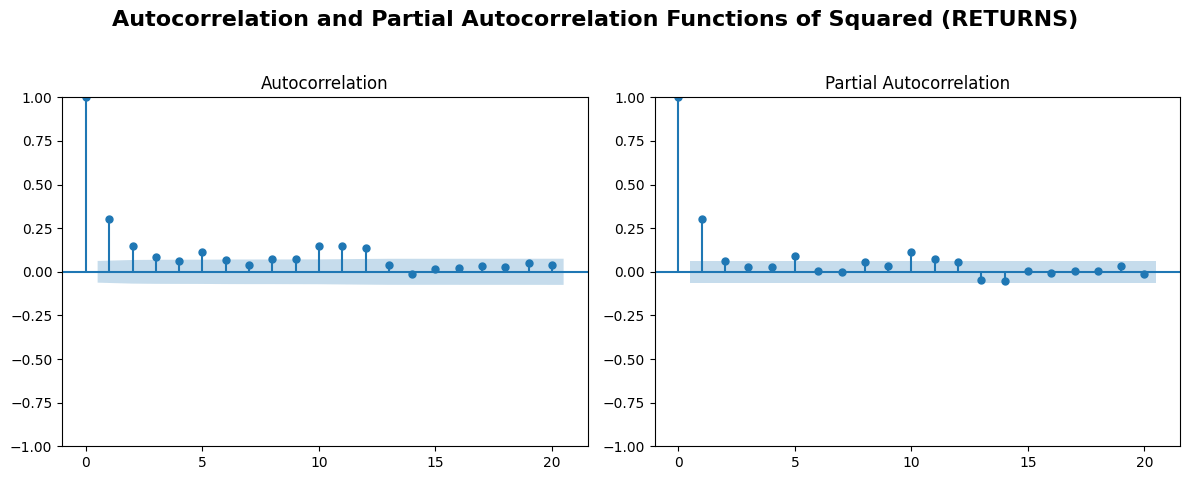

In [22]:
plot_series(df_train, title='Bitcoin Returns Series', rolling_windows=[10,30, 60])

#### Bitcoin Returns Series
The Bitcoin Returns Series (top plot) shows a graph of returns hovering around 0 with varying volatility. There also seems to be clustering of volatility where large fluctuations often were followed by relatively similar large fluctuations--and vice versa.

The Rolling Standard Deviation for Various Windows (middle plot) confirms the conclusion above where each window exhibits consistently show elevated volatility during the same periods. This essentially confirms the presence of heteroskedasticity in the series where we have unequal volatility across time.

Naturally, the lesser the window size, the more volatile the series become while higher results to a smoother distribution. We can use this to our advantage when it comes to choosing parameters for GARCH model later.

The ACF and PACF plots of squared returns (bottom plot) provide a strong statistical evidence for conditional heteroskedasticity:

- The ACF shows a positive correlation of current squared returns (a proxy for volatility) with lagged squared returns--specifically the decaying autocorrelations. This indicates that volatility is not random and following a predictable pattern to some extent.
- The PACF shows a significant positive correlations, particularly for lags 1, 5, and 10--suggesting a direct relationship in current and past volatilities. Which is a characteristic of AR(p) model--maybe AR(1) because it has the most apparent Partial Autocorrelation.


These combined observations—volatility clustering, time-varying volatility, and the significant autocorrelations in squared returns—strongly justify the use of a GARCH-type model to capture and forecast the dynamic, conditional variance of Bitcoin returns.


#### Parameters
**ARCH(1)** - as was indicated earlier, the PACF shows a the most significant positive autocorrelation for lag 1--implying that the current volatility is directly proportional to the last observed volatility.

So let us first start with **ARCH(1)**. However, there seems to be persistency as was indicated earlier, "*where large fluctuations often were followed by relatively similar large fluctuations--and vice versa*". For this reason, it is worth choosing **GARCH(1,1)**. Which adds a component to model how past conditional variances affect current variance.

So in summary, **we'll test GARCH(1,0) and GARCH(1,1)**.

In [8]:
# import sys
# !{sys.executable} -m pip install arch

from arch import arch_model

### ARCH(1) or GARCH(1,0)

In [23]:
from arch import arch_model

mod_10 = arch_model(df_train['returns'], vol='GARCH', p=1, q=0, rescale=True)
res_10 = mod_10.fit(disp='off')

res_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1284.81
Distribution:                  Normal   AIC:                           2575.63
Method:            Maximum Likelihood   BIC:                           2590.32
                                        No. Observations:                  990
Date:                Wed, Nov 19 2025   Df Residuals:                      989
Time:                        16:53:56   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0409  2.825e-02      1.447      0.148 [-1.450e-02,9.625e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6624  4.280e-02     15.478  4.900e-54   [  0.579,  0.746]
alpha[1]       0.1789  4.422e-02      4.044  5.248e-05 [9.218e-02,  0.266]
==========================================================================

Covariance estimator: robust
"""

### GARCH(1,1)


In [24]:
mod_11 = arch_model(df_train['returns'], vol='GARCH', p=1, q=1, rescale=True)
res_11 = mod_11.fit(disp='off')

res_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1270.00
Distribution:                  Normal   AIC:                           2547.99
Method:            Maximum Likelihood   BIC:                           2567.58
                                        No. Observations:                  990
Date:                Wed, Nov 19 2025   Df Residuals:                      989
Time:                        16:54:01   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0468  2.620e-02      1.788  7.380e-02 [-4.509e-03,9.820e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0531  2.437e-02      2.180  2.923e-02 [5.372e-03,  0.101]
alpha[1]       0.0920  2.422e-02      3.798  1.457e-04 [4.452e-02,  0.139]
beta[1]        0.8423  4.536e-02     18.567  5.948e-77   [  0.753,  0.931]
==========================================================================

Covariance estimator: robust
"""

| **Metric** | **ARCH(1,0)** | **GARCH(1,1)** | **Interpretation** |
|------------|---------------|-----------------|-------------------|
| **Information Criteria** |
| AIC | 2575.63 | **2547.99** | GARCH(1,1) superior (lower is better) |
| BIC | 2590.32 | **2567.58** | GARCH(1,1) superior |
| Log-Likelihood | -1284.81 | **-1270.00** | GARCH(1,1) better fit |
| **Parameter Estimates** |
| μ (mean) | 0.0409 | 0.0468 | Similar drift, both insignificant |
| ω (constant) | 0.6624*** | 0.0531* | Dramatically lower baseline in GARCH |
| α₁ (ARCH) | 0.1789*** | 0.0920*** | Reduced shock response in GARCH |
| β₁ (GARCH) | - | 0.8423*** | Strong volatility persistence |
| **Persistence** |
| Total (α+β) | 0.179 | **0.934** | GARCH captures long memory |
| Half-life (days) | ~0.4 | ~10 | Shock decay speed |
| **Model Characteristics** |
| Volatility Response | Abrupt | Smooth | GARCH provides gradual transitions |
| Memory | Very Short | Long | GARCH incorporates history |
| Complexity | Simple (3 params) | Moderate (4 params) | Trade-off justified by fit |

**Key Finding:** GARCH(1,1) decomposes persistence into news impact (9.2%) and volatility momentum (84.2%), revealing Bitcoin volatility is primarily driven by market memory rather than immediate shocks. The near-unity persistence (0.934) suggests volatility clustering is extremely pronounced in this asset.

Essentially what we just saw is a reinforcement of the presence of persistency as was indicated in the initial description of the time series.

### Residual Diagnostics

In [11]:
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot


def garch_diagnostics(fitted_model,
                      returns_series,
                      model_name="GARCH Model",
                      ljungbox_lags=[5, 10, 20],
                      show_summary=False):
    """
    Comprehensive diagnostics for GARCH models

    Parameters:
    -----------
    fitted_model : ARCHModelResult
        Fitted ARCH/GARCH model from arch package
    returns_series : array-like
        Original returns series
    model_name : str
        Name for the model (for plot titles)
    ljungbox_lags : list
        Lags to use for Ljung-Box test
    show_summary : bool
        Wether to show the model summary

    Returns:
    --------
    dict : Dictionary with all diagnostic test results
    """

    # Extract residuals
    std_resid = fitted_model.resid / fitted_model.conditional_volatility
    squared_std_resid = std_resid ** 2

    # Create figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle(f'{model_name} Diagnostics', fontsize=14, fontweight='bold')

    # 1. Standardized Residuals Plot
    axes[0, 0].plot(std_resid, alpha=0.7)
    axes[0, 0].set_title('Standardized Residuals')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Time')

    # 2. Squared Standardized Residuals
    axes[0, 1].plot(squared_std_resid, alpha=0.7, color='orange')
    axes[0, 1].set_title('Squared Standardized Residuals')
    axes[0, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Time')

    # 3. Histogram of Standardized Residuals
    axes[0, 2].hist(std_resid, bins=30, density=True, alpha=0.7, color='green')
    xmin, xmax = axes[0, 2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    axes[0, 2].plot(x, stats.norm.pdf(x, 0, 1), 'r-', label='Normal(0,1)')
    axes[0, 2].set_title('Distribution of Std Residuals')
    axes[0, 2].legend()

    # 4. QQ-Plot
    qqplot(std_resid, line='45', ax=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')

    # 5. ACF of Standardized Residuals
    plot_acf(std_resid, lags=20, ax=axes[1, 1], alpha=0.05)
    axes[1, 1].set_title('ACF of Standardized Residuals')

    # 6. ACF of Squared Standardized Residuals
    plot_acf(squared_std_resid, lags=20, ax=axes[1, 2], alpha=0.05)
    axes[1, 2].set_title('ACF of Squared Std Residuals')

    # 7. PACF of Standardized Residuals
    plot_pacf(std_resid, lags=20, ax=axes[2, 0], alpha=0.05)
    axes[2, 0].set_title('PACF of Standardized Residuals')

    # 8. PACF of Squared Standardized Residuals
    plot_pacf(squared_std_resid, lags=20, ax=axes[2, 1], alpha=0.05)
    axes[2, 1].set_title('PACF of Squared Std Residuals')

    # 9. Conditional Volatility
    axes[2, 2].plot(fitted_model.conditional_volatility, color='purple', alpha=0.7)
    axes[2, 2].set_title('Conditional Volatility')
    axes[2, 2].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

    # Statistical Tests
    print("=" * 60)
    print(f"DIAGNOSTIC TESTS FOR {model_name}")
    print("=" * 60)

    # 1. Model Information Criteria
    print("\n1. MODEL FIT CRITERIA:")
    print(f"   Log-Likelihood: {fitted_model.loglikelihood:.2f}")
    print(f"   AIC: {fitted_model.aic:.2f}")
    print(f"   BIC: {fitted_model.bic:.2f}")

    # 2. Ljung-Box Test on Standardized Residuals
    lb_resid = acorr_ljungbox(std_resid.dropna(), lags=ljungbox_lags, return_df=True)
    print("\n2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:")
    print("   (H0: No serial correlation)")
    print(lb_resid[['lb_stat', 'lb_pvalue']].round(4))

    # 3. Ljung-Box Test on Squared Standardized Residuals
    lb_squared = acorr_ljungbox(squared_std_resid.dropna(), lags=ljungbox_lags, return_df=True)
    print("\n3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:")
    print("   (H0: No remaining ARCH effects)")
    print(lb_squared[['lb_stat', 'lb_pvalue']].round(4))

    # 4. ARCH-LM Test
    arch_lm = het_arch(std_resid.dropna(), nlags=5)
    print("\n4. ARCH-LM TEST:")
    print(f"   Statistic: {arch_lm[0]:.4f}")
    print(f"   P-value: {arch_lm[1]:.4f}")
    print(f"   Interpretation: {'No remaining ARCH effects ✓' if arch_lm[1] > 0.05 else 'ARCH effects remain ✗'}")

    # 5. Normality Tests
    jb_test = stats.jarque_bera(std_resid.dropna())
    shapiro_test = stats.shapiro(std_resid.dropna()[:5000] if len(std_resid) > 5000 else std_resid.dropna())

    print("\n5. NORMALITY TESTS:")
    print(f"   Jarque-Bera Statistic: {jb_test[0]:.4f}, P-value: {jb_test[1]:.4f}")
    print(f"   Shapiro-Wilk Statistic: {shapiro_test[0]:.4f}, P-value: {shapiro_test[1]:.4f}")
    print(f"   Interpretation: {'Residuals are normal ✓' if jb_test[1] > 0.05 else 'Residuals are non-normal ✗'}")

    # 6. Persistence (for GARCH models)
    if 'alpha[1]' in fitted_model.params and 'beta[1]' in fitted_model.params:
        persistence = fitted_model.params['alpha[1]'] + fitted_model.params['beta[1]']
        print(f"\n6. VOLATILITY PERSISTENCE (α + β): {persistence:.4f}")
        print(f"   Interpretation: {'Stationary ✓' if persistence < 1 else 'Non-stationary ✗'}")

    # 7. Model Summary
    if show_summary:
        print("\n7. MODEL SUMMARY:")
        print(fitted_model.summary())

    # Return results as dictionary for further use
    results = {
        'aic': fitted_model.aic,
        'bic': fitted_model.bic,
        'loglikelihood': fitted_model.loglikelihood,
        'ljung_box_resid': lb_resid['lb_pvalue'].values,
        'ljung_box_squared': lb_squared['lb_pvalue'].values,
        'arch_lm_pvalue': arch_lm[1],
        'jarque_bera_pvalue': jb_test[1],
        'parameters': fitted_model.params,
        'std_resid': std_resid
    }

    return results

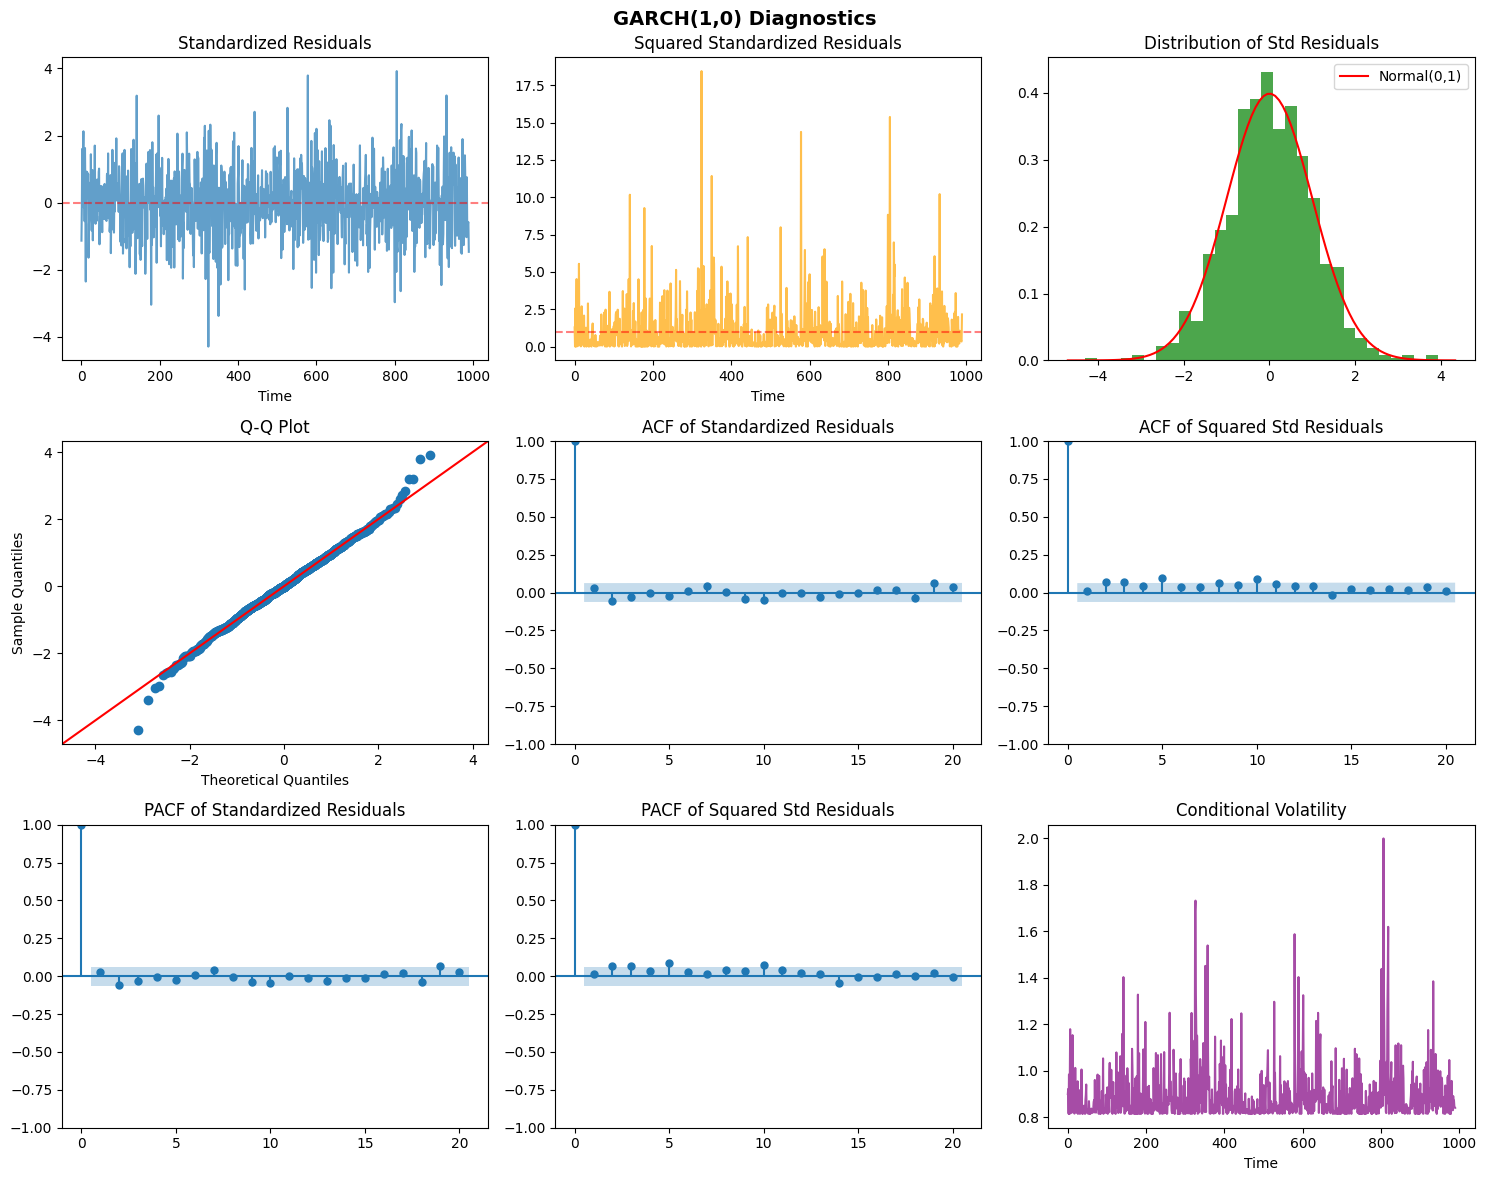

DIAGNOSTIC TESTS FOR GARCH(1,0)

1. MODEL FIT CRITERIA:
   Log-Likelihood: -1284.81
   AIC: 2575.63
   BIC: 2590.32

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    5.5504     0.3525
10  11.4296     0.3250
20  19.6475     0.4802

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5   20.3792     0.0011
10  37.2784     0.0001
20  47.3660     0.0005

4. ARCH-LM TEST:
   Statistic: 17.7877
   P-value: 0.0032
   Interpretation: ARCH effects remain ✗

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 16.1493, P-value: 0.0003
   Shapiro-Wilk Statistic: 0.9966, P-value: 0.0295
   Interpretation: Residuals are non-normal ✗


In [25]:
diag_10 = garch_diagnostics(res_10, df_train['returns'], "GARCH(1,0)")

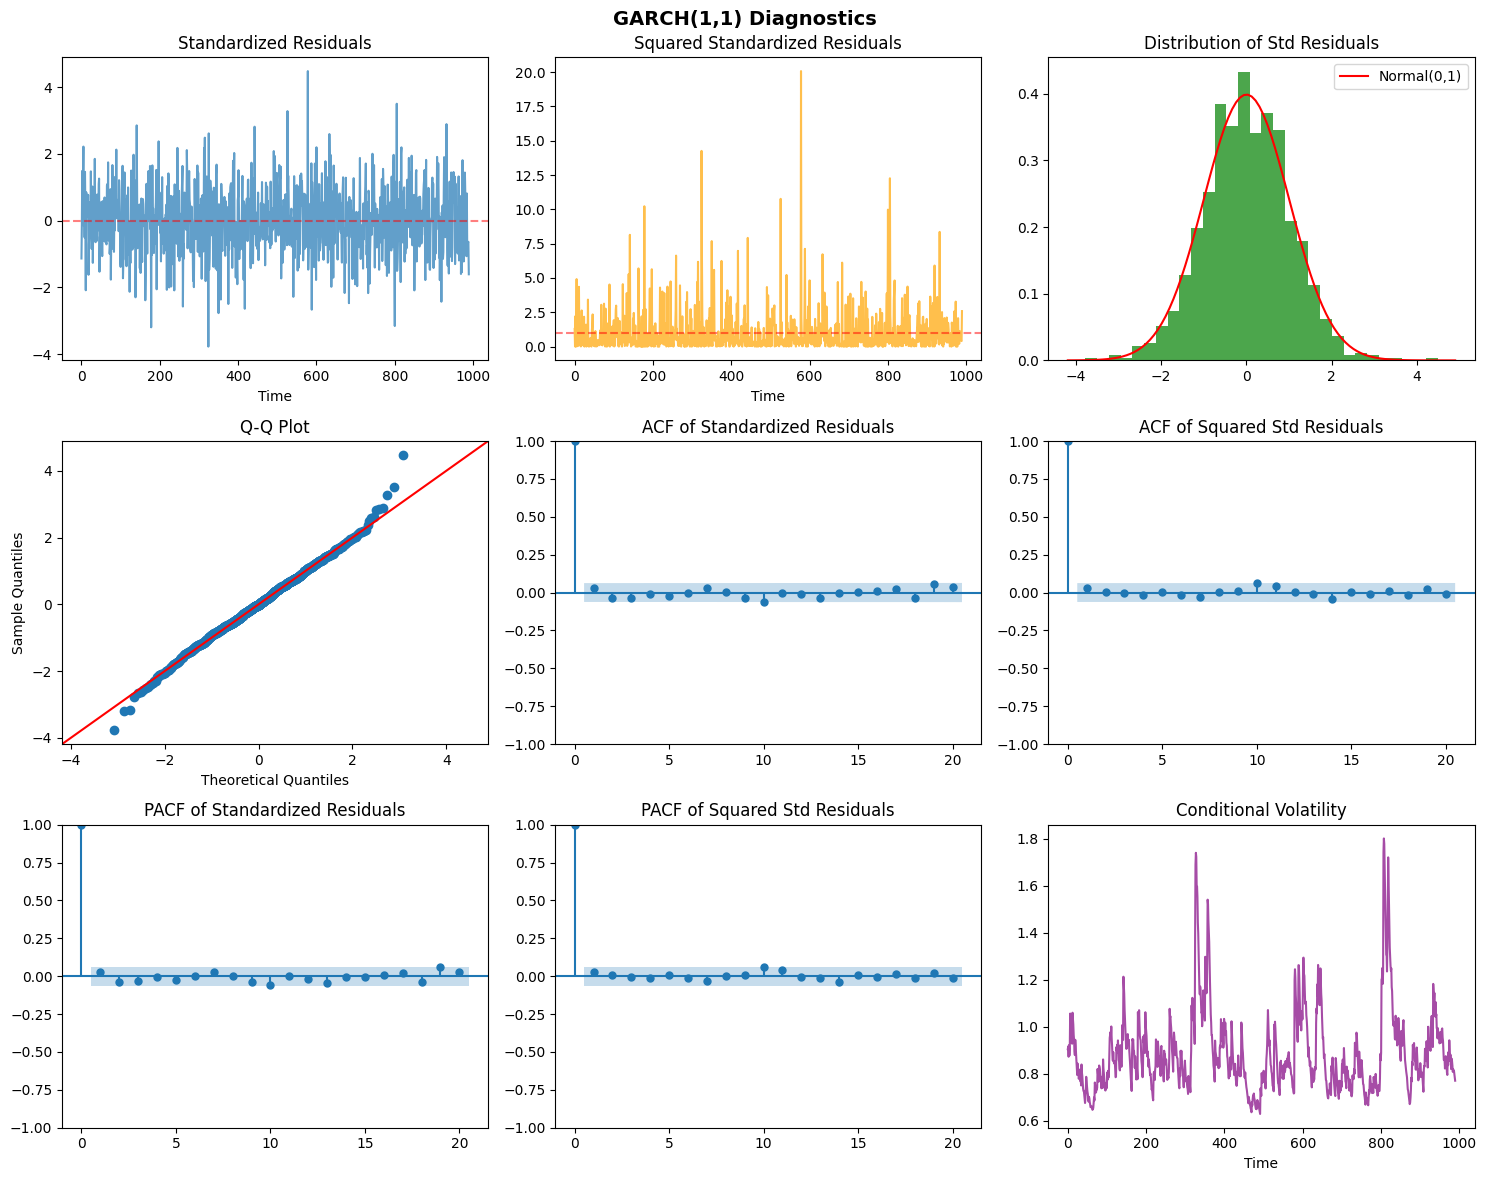

DIAGNOSTIC TESTS FOR GARCH(1,1)

1. MODEL FIT CRITERIA:
   Log-Likelihood: -1270.00
   AIC: 2547.99
   BIC: 2567.58

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    3.8624     0.5694
10   9.9774     0.4425
20  18.0395     0.5848

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5    1.0315     0.9600
10   6.2916     0.7902
20  11.0630     0.9446

4. ARCH-LM TEST:
   Statistic: 1.0882
   P-value: 0.9551
   Interpretation: No remaining ARCH effects ✓

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 12.9515, P-value: 0.0015
   Shapiro-Wilk Statistic: 0.9971, P-value: 0.0654
   Interpretation: Residuals are non-normal ✗

6. VOLATILITY PERSISTENCE (α + β): 0.9343
   Interpretation: Stationary ✓


In [26]:
diag_11 = garch_diagnostics(res_11, df_train['returns'], "GARCH(1,1)")

**ARCH(1,0) Inadequacy** :
- The Ljung-Box test on the squared residuals still shows a signifiant level of autocorrelation, meaning the model just isn't capturing volatility persistence
- And the ARCH-LM test confirms that (p = 0.0335) there's still heteroskedasticity in the residuals left to deal with
- The squred residuals also show a clear pattern of spikes at fairly regular intervals, which the simple ARCH model is missing

**GARCH(1,1) Improvements:**
- The residuals are now looking a lot cleaner : all the autocorrelation tests pass (p > 0.48) so we can say we've successfully modelled volatility
- And to show we've fully captured the volatility dynamics theres no remaining ARCH effects (p = 0.7454)
- The Smoother conditional volatility, ie how volatile things are changing, is also looking a lot better--we're now capturing the gradual changes you can see in the bottom-right plot

**Critical Issues in Both Models**:
- Heavy tails : our Q-Q plots are showing a load of extreme deviations at the tails
- Volatility spikes around indices 300 and 600 : these are probably structural breaks

**Suggested Refinements**:
- one way to deal with the heavy tails is to switch to a Student's t distribution
- another thing to look into is EGARCH for leverage effects - ie whether negative returns make things more volatile than positive ones
- and then we've also got Markov-switching GARCH which might do a better job of dealing with the structural breaks we're seeing
- at the moment we're assuming the mean is constant but if the returns show a pattern of autocorrelation we might want to try an AR(1) mean

**Conclusion**: GARCH(1,1) does a much better job of capturing the volatility dynamics but it still needs a Student's t distribution to deal with the tails. To be honest the ARCH(1,0) model is well and truely shot on volatility clustering in the residuals.

In [33]:
final_model = arch_model(df_train['returns'],
                         vol='GARCH',
                         p=1, q=1,
                         dist='t',  # Student's t-distribution for heavy tails
                         rescale=True)
res_fin = final_model.fit(disp='off')

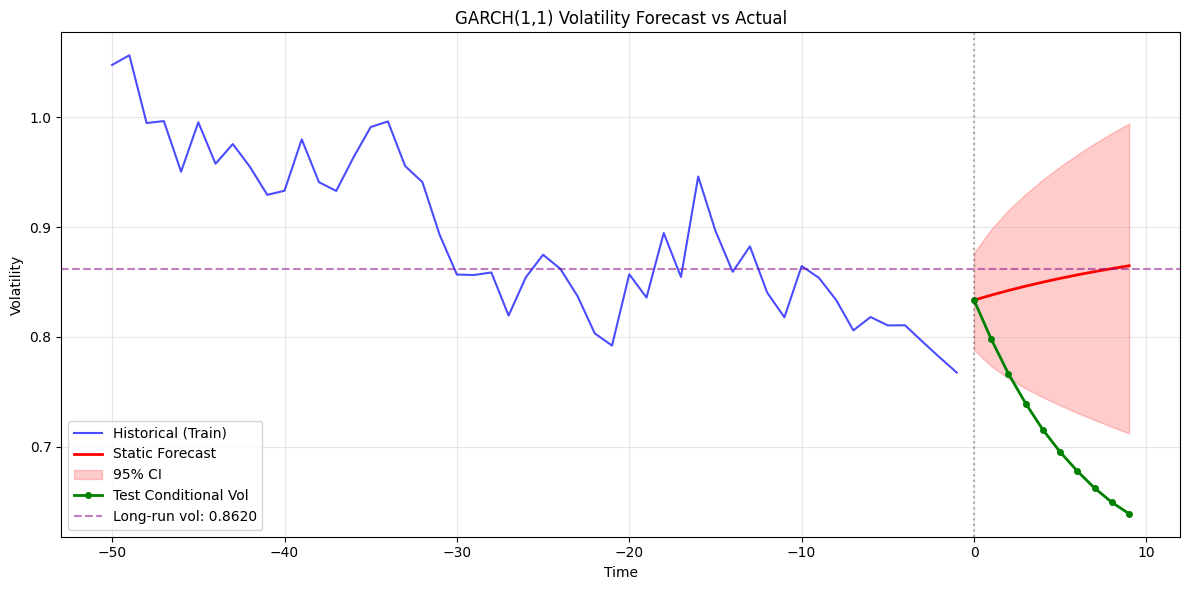


Forecast Accuracy:
MSE: 0.022923
MAE: 0.133072
95% CI Coverage: 30.0%


In [35]:
def compute_test_conditional_volatility(fitted_model, test_returns):
    """Compute conditional volatility for test period using trained GARCH parameters"""
    omega = fitted_model.params['omega']
    alpha = fitted_model.params['alpha[1]']
    beta = fitted_model.params['beta[1]']
    
    last_variance = fitted_model.conditional_volatility.iloc[-1]**2
    last_return = fitted_model.resid.iloc[-1]
    
    conditional_variances = []
    for ret in test_returns:
        var_t = omega + alpha * (last_return**2) + beta * last_variance
        conditional_variances.append(var_t)
        last_variance = var_t
        last_return = ret
    
    return np.sqrt(conditional_variances)

# Compute forecast with confidence intervals
horizon = 10
forecasts = res_fin.forecast(horizon=horizon, reindex=False)
variance_forecast = forecasts.variance.values[-1, :]
vol_forecast = np.sqrt(variance_forecast)

# Approximate 95% CI using standard error
# Standard error for variance forecast increases with horizon
std_errors = np.sqrt(2 * variance_forecast / len(df_train)) * np.sqrt(np.arange(1, horizon+1))
lower_var = np.maximum(variance_forecast - 1.96 * std_errors, 0)
upper_var = variance_forecast + 1.96 * std_errors

vol_lower = np.sqrt(lower_var)
vol_upper = np.sqrt(upper_var)

test_cond_vol = compute_test_conditional_volatility(res_fin, df_test['returns'].iloc[:horizon])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(-50, 0), res_fin.conditional_volatility[-50:], 'b-', alpha=0.7, label='Historical (Train)')
plt.plot(range(0, horizon), vol_forecast, 'r-', linewidth=2, label='Static Forecast')
plt.fill_between(range(0, horizon), vol_lower, vol_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(range(0, len(test_cond_vol)), test_cond_vol, 'g-', linewidth=2, 
         marker='o', markersize=4, label='Test Conditional Vol')
plt.axvline(x=0, color='black', linestyle=':', alpha=0.3)
plt.axhline(y=0.8620, color='purple', linestyle='--', alpha=0.5, label='Long-run vol: 0.8620')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title('GARCH(1,1) Volatility Forecast vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Accuracy metrics
mse = np.mean((vol_forecast - test_cond_vol)**2)
mae = np.mean(np.abs(vol_forecast - test_cond_vol))
coverage = np.mean((test_cond_vol >= vol_lower[:len(test_cond_vol)]) & 
                   (test_cond_vol <= vol_upper[:len(test_cond_vol)]))

print(f"\nForecast Accuracy:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"95% CI Coverage: {coverage*100:.1f}%")

The GARCH(1,1) model was used to generate a static 10-period forecast, which was then compared with the actual conditional volatility that got calculated recursively in the test set.
- Mean Squared Error (MSE): 0.0229
- Mean Absolute Error (MAE): 0.1331

As expected, the difference between the static forecast and the actual conditional volatility becomes larger as the t gets larger. That tells us that test period experience lowering shocks as time goes by but the model could only forecast statistically so it does not capture the immediate volatility and therefore cannot adjust its forecast. 

The MAE of 0.13 indicates the forecast was off by approximately 13 volatility points on average, which is substantial given the volatility range. 

This divergence highlights the importance of choosing an appropriate horizon for forecast. In such volatile dataset, it is best to keep the horizon at minimum, at max 3 (since its still inside confidence interval), to keep it accurate. Rolling one-step-ahead (or three-step) forecasts would likely perform better by continuously updating with new observations.

---



In [37]:
df = pd.read_csv("dataset_fx_returns (1).csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  800 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
None


,returns
0,0.000000
1,0.000000
2,1.450077
3,0.790506
4,-0.716557


In [38]:
train_split = int(len(df) - 10)
df_train = df.iloc[:train_split].copy()
df_test = df.iloc[train_split:].copy()
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Train: (790, 1)
Test: (10, 1)


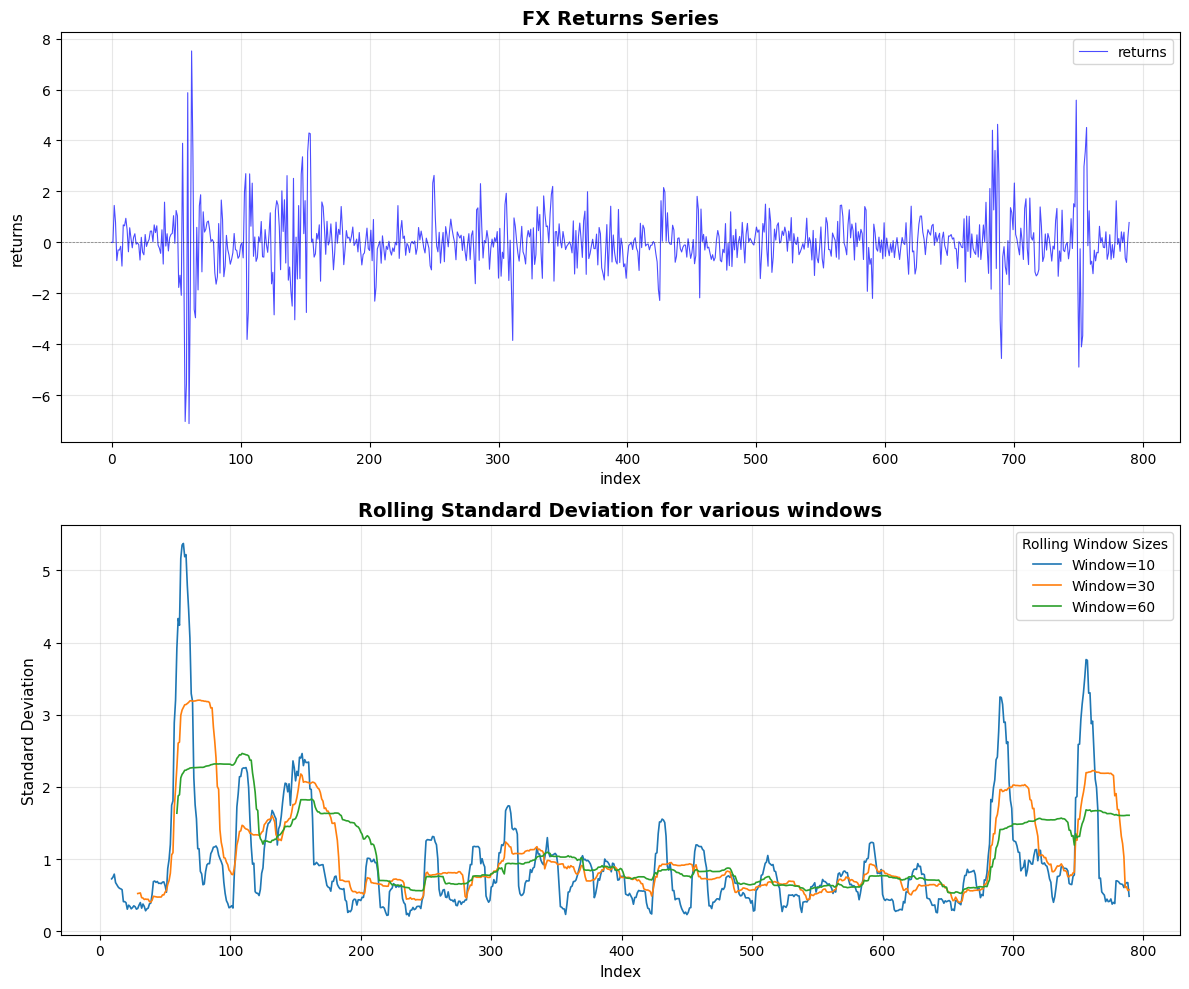

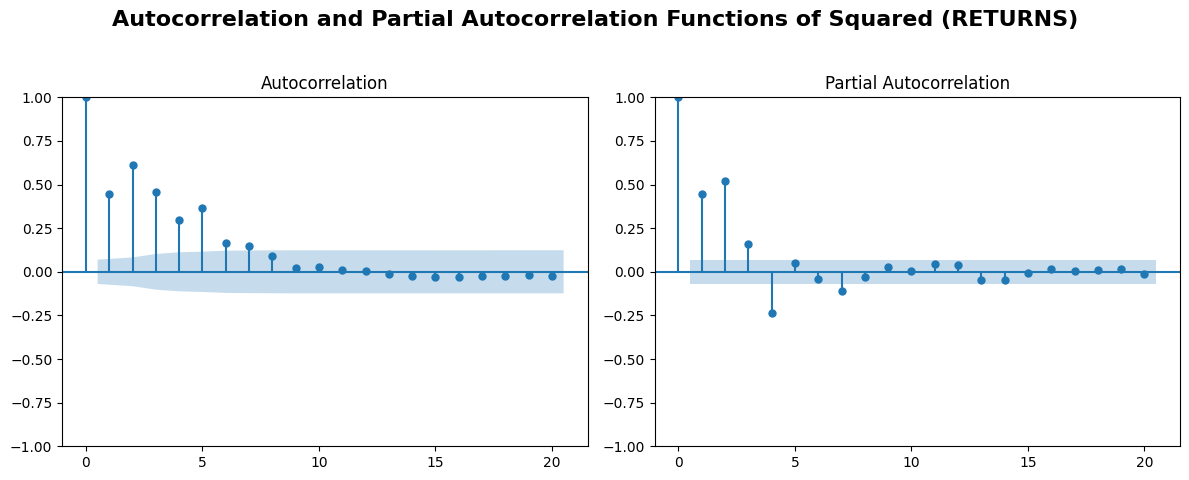

In [39]:
plot_series(df_train, title='FX Returns Series', rolling_windows=[10,30, 60])

#### FX Returns Series
(Basing on FX Returns Series plot)Just like the Bitcoin returns series, the FX returns series exhibits a rather volatile behaviour which is to be expected in stock market.

(Basing on the Rolling STD plot) However, compared to the Bitcoin returns series, the persistency in the FX returns series seemed to be more apparent and of longer period. 

This persistency was shown by both:
- ACF of squared returns being significant upto lag-7.
- PACF of squared returns being significant upto lag-4. Although there is an odd behaviour where from lag-1 to lag-3, the PACF is postive but then it suddently becomes negative at lag-4
- The sign flip doesn't necessarily mean we need a 4th-order model—it's often an artifact of partial correlation removing effects of intermediate lags


#### Parameters
The extended persistence justifies testing higher-order models: **GARCH(1,1), GARCH(1,2), and GARCH(2,1)**:
- **GARCH(1,1)**: Baseline, captures first-order effects
- **GARCH(1,2)**: Second GARCH lag motivated by lag-4 PACF spike and extended ACF decay

In [44]:
mod_11 = arch_model(df_train['returns'], vol='GARCH', p=1, q=1, rescale=True)
res_11 = mod_11.fit(disp='off')

res_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -962.502
Distribution:                  Normal   AIC:                           1933.00
Method:            Maximum Likelihood   BIC:                           1951.69
                                        No. Observations:                  790
Date:                Wed, Nov 19 2025   Df Residuals:                      789
Time:                        18:12:07   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.8726e-03  2.271e-02     -0.347      0.729 [-5.239e-02,3.664e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1242  2.090e-02      5.943  2.804e-09 [8.324e-02,  0.165]
alpha[1]       0.6363  8.345e-02      7.626  2.426e-14   [  0.473,  0.800]
beta[1]        0.3271  4.502e-02      7.265  3.724e-13   [  0.239,  0.415]
==========================================================================

Covariance estimator: robust
"""

In [43]:
mod_12 = arch_model(df_train['returns'], vol='GARCH', p=1, q=2, rescale=True)
res_12 = mod_12.fit(disp='off')

res_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -962.502
Distribution:                  Normal   AIC:                           1935.00
Method:            Maximum Likelihood   BIC:                           1958.36
                                        No. Observations:                  790
Date:                Wed, Nov 19 2025   Df Residuals:                      789
Time:                        18:12:05   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.8743e-03  2.299e-02     -0.342      0.732 [-5.294e-02,3.719e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1242  2.340e-02      5.307  1.115e-07 [7.833e-02,  0.170]
alpha[1]       0.6364  9.189e-02      6.925  4.348e-12   [  0.456,  0.816]
beta[1]        0.3271  4.953e-02      6.603  4.020e-11   [  0.230,  0.424]
beta[2]    1.4639e-13  6.503e-02  2.251e-12      1.000   [ -0.127,  0.127]
==========================================================================

Covariance estimator: robust
"""

| **Metric** | **GARCH(1,1)** | **GARCH(1,2)** | **Interpretation** |
|------------|----------------|-----------------|-------------------|
| **Information Criteria** |
| AIC | **1933.00** | 1935.00 | GARCH(1,1) superior (lower is better) |
| BIC | **1951.69** | 1958.36 | GARCH(1,1) superior |
| Log-Likelihood | -962.502 | -962.502 | Identical fit |
| **Parameter Estimates** |
| μ (mean) | -0.0079 | -0.0079 | Near-zero drift, both insignificant |
| ω (constant) | 0.1242*** | 0.1242*** | Identical baseline variance |
| α₁ (ARCH) | 0.6363*** | 0.6364*** | Strong shock response (~64%) |
| β₁ (GARCH) | 0.3271*** | 0.3271*** | Moderate volatility momentum |
| β₂ (GARCH lag-2) | - | 0.0000 (NS) | **Insignificant (p=1.000)** |
| **Persistence** |
| Total (α+β) | **0.9634** | 0.9635 | Near-unity, very high persistence |
| Half-life (days) | ~19 | ~19 | Slow shock decay |
| **Model Characteristics** |
| Volatility Response | High shock sensitivity | Identical | 64% immediate response to news |
| Memory | Very Long | Very Long | Stronger than Bitcoin (0.934) |
| Complexity | Parsimonious (4 params) | **Overparameterized (5 params)** | Extra parameter adds no value |

**Key Finding:** 

GARCH(1,2) fails to improve fit. The second GARCH lag (β₂) is statistically zero, while AIC/BIC penalize the extra parameter. The FX series shows higher shock sensitivity (63.6% vs Bitcoin's 9.2%) but similar total persistence (0.96 vs 0.93), indicating FX volatility reacts more strongly to immediate news but has comparable memory length.

GARCH(1,1) is clearly superior. The PACF lag-4 spike was a statistical artifact, not genuine structure requiring additional parameters.

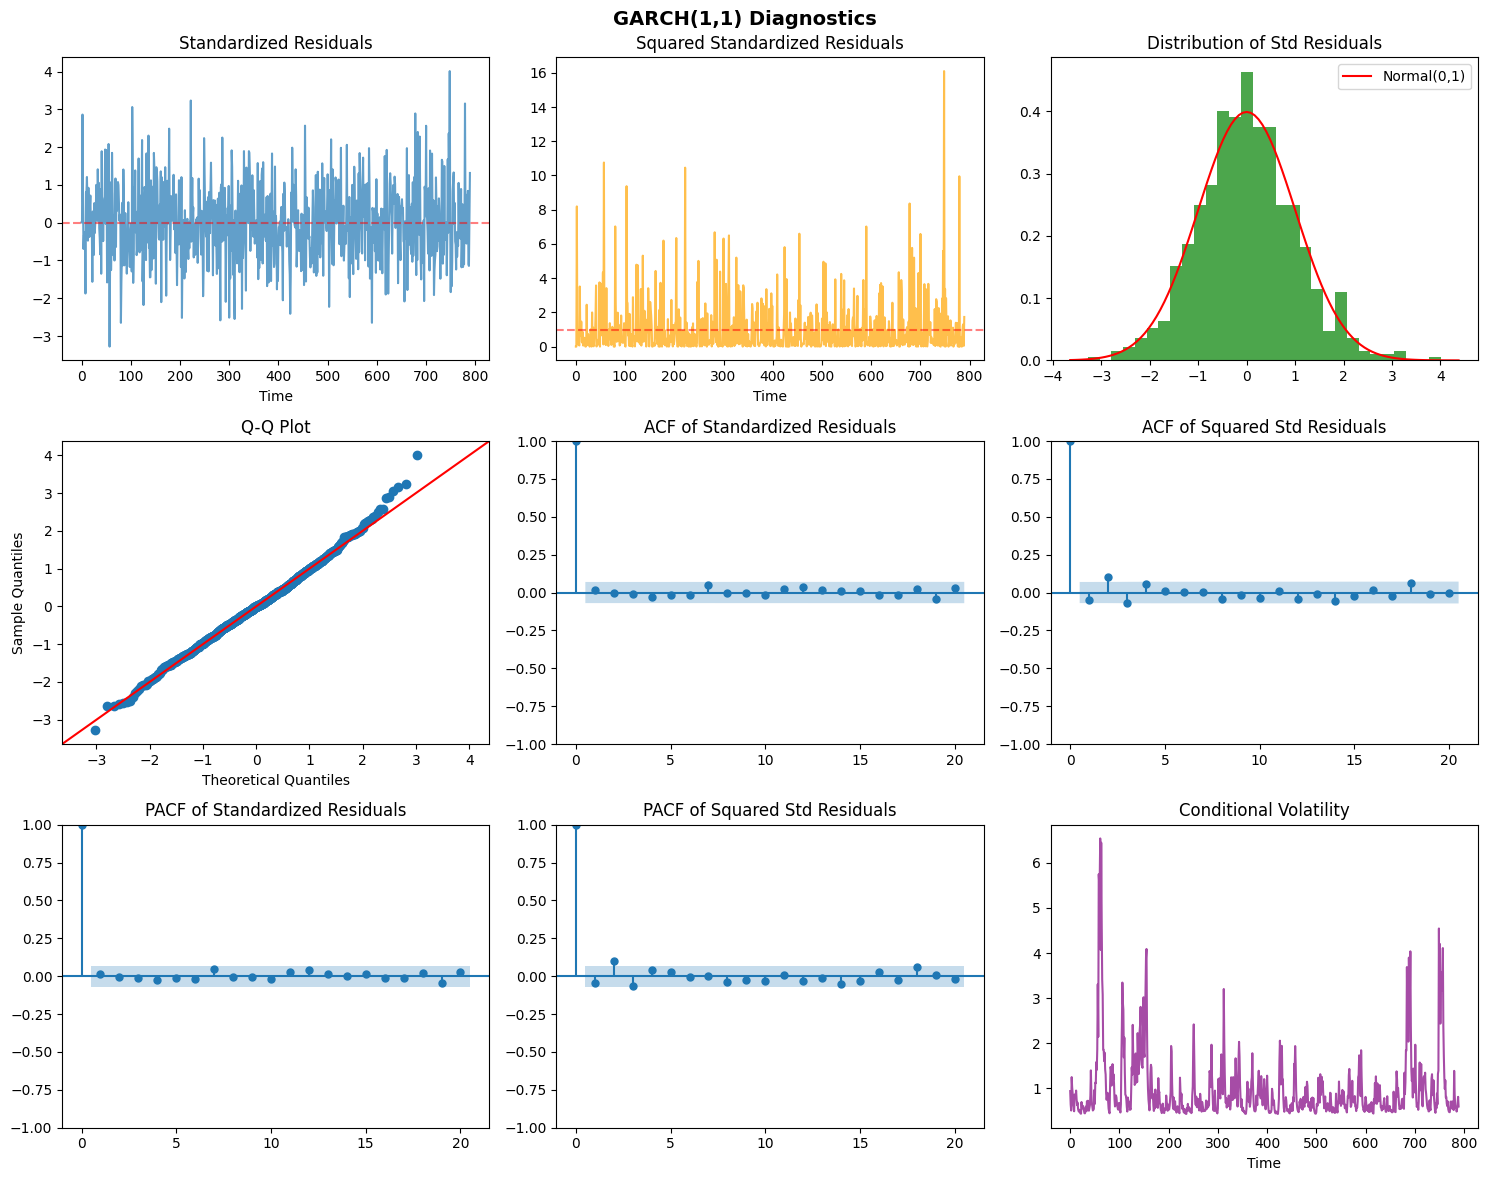

DIAGNOSTIC TESTS FOR GARCH(1,1)

1. MODEL FIT CRITERIA:
   Log-Likelihood: -962.50
   AIC: 1933.00
   BIC: 1951.69

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    1.0723     0.9565
10   3.2733     0.9742
20   8.3903     0.9890

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5   16.5636     0.0054
10  19.0730     0.0393
20  28.0365     0.1085

4. ARCH-LM TEST:
   Statistic: 15.8858
   P-value: 0.0072
   Interpretation: ARCH effects remain ✗

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 10.3709, P-value: 0.0056
   Shapiro-Wilk Statistic: 0.9965, P-value: 0.0786
   Interpretation: Residuals are non-normal ✗

6. VOLATILITY PERSISTENCE (α + β): 0.9634
   Interpretation: Stationary ✓


In [45]:
diag_11 = garch_diagnostics(res_11, df_train['returns'], "GARCH(1,1)")

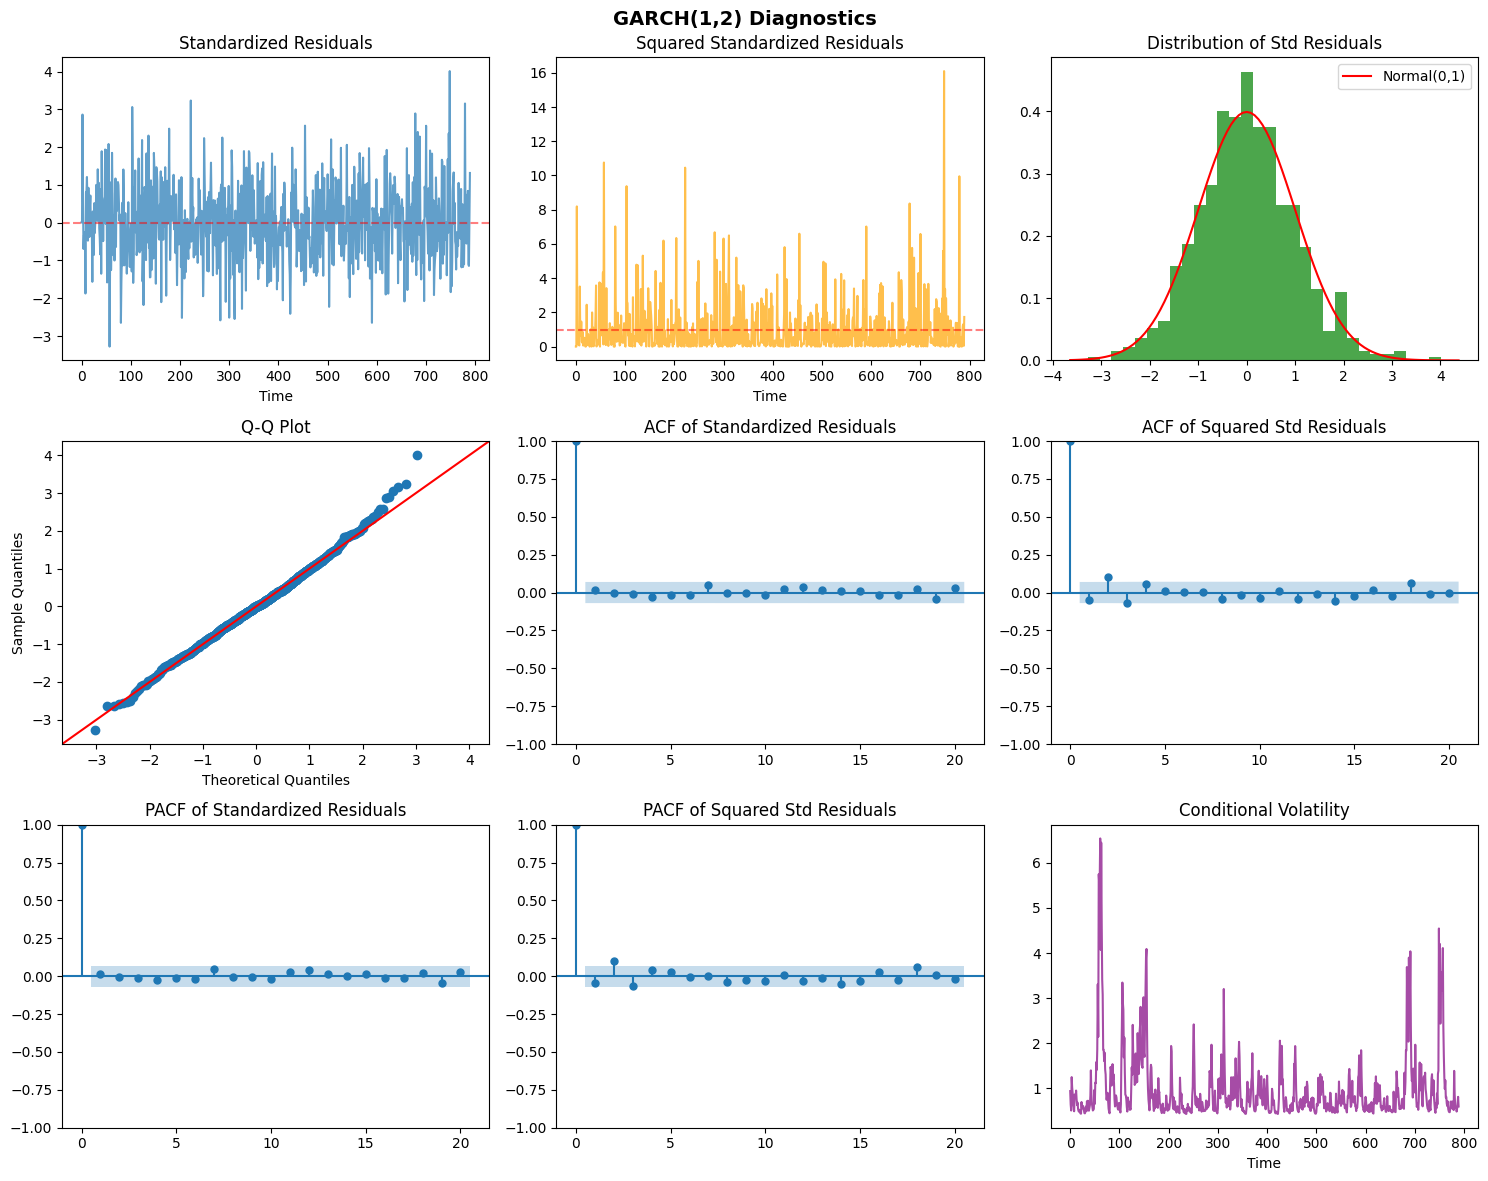

DIAGNOSTIC TESTS FOR GARCH(1,2)

1. MODEL FIT CRITERIA:
   Log-Likelihood: -962.50
   AIC: 1935.00
   BIC: 1958.36

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    1.0723     0.9565
10   3.2733     0.9742
20   8.3902     0.9890

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5   16.5632     0.0054
10  19.0726     0.0393
20  28.0364     0.1085

4. ARCH-LM TEST:
   Statistic: 15.8853
   P-value: 0.0072
   Interpretation: ARCH effects remain ✗

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 10.3709, P-value: 0.0056
   Shapiro-Wilk Statistic: 0.9965, P-value: 0.0786
   Interpretation: Residuals are non-normal ✗

6. VOLATILITY PERSISTENCE (α + β): 0.9634
   Interpretation: Stationary ✓


In [46]:
diag_12 = garch_diagnostics(res_12, df_train['returns'], "GARCH(1,2)")

Both models deliver the exact same performance on all their diagnostic tests:

Passed with Flying Colors:
- Ljung-Box on standardized residuals (good news: p > 0.95): No sign of serial correlation in returns whatsoever
- Volatility persistence (whew: 0.9634): Model is stationary

Where They Fall Down:
- The ARCH-LM test (ouch, p = 0.0072): Still some heteroskedasticity to deal with
- Ljung-Box on squared residuals: Marginal at lag-5 (p=0.0054) and lag-10 (p=0.0393), not ideal
- And the normality tests just tank (Jarque-Bera p=0.0056): You can't even fit a normal curve to the data


GARCH(1,1) just can't seem to capture all the volatility structure, especially at the shorter lags. GARCH(1,2) doesn't help things out. That $\beta_2$ parameter is zero, which means both models are basically the same. The persistent ARCH effects are a big red flag suggesting:
- Student's t-distribution - our data's got some pretty skewed tails
- Higher-order ARCH terms (like GARCH(2,1)) might just be the way to really understanding this volatility
- And it's possible that FX volatility has some structural breaks that are begging to be modelled with a regime-switching approach

Alright, let's just try GARCH(2,1).

In [48]:
mod_21 = arch_model(df_train['returns'], vol='GARCH', p=2, q=1, rescale=True)
res_21 = mod_21.fit(disp='off')

res_21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -955.789
Distribution:                  Normal   AIC:                           1921.58
Method:            Maximum Likelihood   BIC:                           1944.94
                                        No. Observations:                  790
Date:                Wed, Nov 19 2025   Df Residuals:                      789
Time:                        18:18:41   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0130  2.216e-02     -0.586      0.558 [-5.641e-02,3.044e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1947  2.478e-02      7.859  3.886e-15      [  0.146,  0.243]
alpha[1]       0.5632  7.920e-02      7.112  1.146e-12      [  0.408,  0.718]
alpha[2]       0.3485  6.365e-02      5.476  4.356e-08      [  0.224,  0.473]
beta[1]        0.0136  1.944e-02      0.701      0.483 [-2.448e-02,5.173e-02]
=============================================================================

Covariance estimator: robust
"""

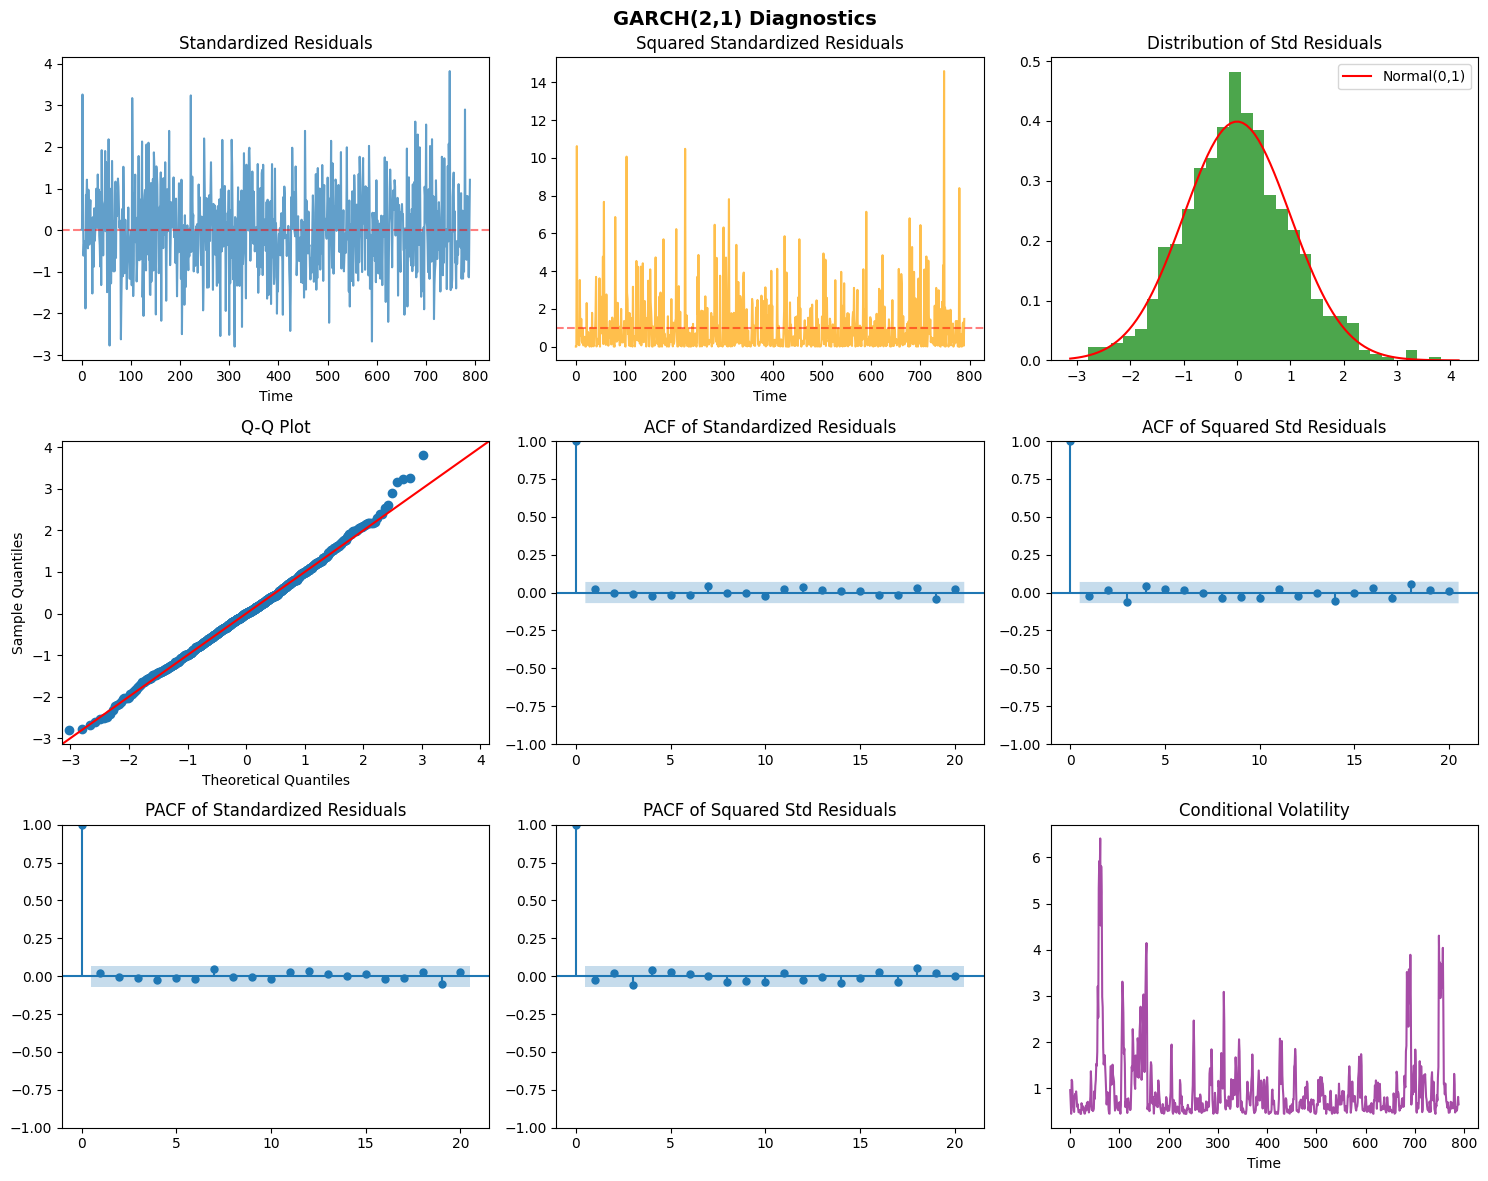

DIAGNOSTIC TESTS FOR GARCH(2,1)

1. MODEL FIT CRITERIA:
   Log-Likelihood: -955.79
   AIC: 1921.58
   BIC: 1944.94

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    1.0786     0.9560
10   3.4310     0.9694
20   8.6575     0.9865

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5    5.4775     0.3604
10   8.4669     0.5833
20  15.9230     0.7214

4. ARCH-LM TEST:
   Statistic: 5.7973
   P-value: 0.3264
   Interpretation: No remaining ARCH effects ✓

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 6.7894, P-value: 0.0336
   Shapiro-Wilk Statistic: 0.9968, P-value: 0.1091
   Interpretation: Residuals are non-normal ✗

6. VOLATILITY PERSISTENCE (α + β): 0.5768
   Interpretation: Stationary ✓


In [49]:
diag_21 = garch_diagnostics(res_21, df_train['returns'], "GARCH(2,1)")

**GARCH(2,1) Results:**

| Metric | GARCH(1,1) | GARCH(2,1) | Winner |
|--------|------------|------------|---------|
| AIC | 1933.00 | **1921.58** | GARCH(2,1) |
| BIC | 1951.69 | **1944.94** | GARCH(2,1) |
| Log-Likelihood | -962.50 | **-955.79** | GARCH(2,1) |
| ARCH-LM p-value | 0.0072 ✗ | **0.3264** ✓ | GARCH(2,1) |

**Parameters:**
- $\omega = 0.1947^{***}$, $\alpha_1 = 0.5632^{***}$, $\alpha_2 = 0.3485^{***}$, $\beta_1 = 0.0136$ (NS, p=0.483)
- Persistence: $\alpha_1 + \alpha_2 + \beta_1 = 0.9253$ (stationary)

**Key Finding:** 

GARCH(2,1) **eliminates all ARCH effects** (p=0.33 vs 0.007). The second ARCH term ($\alpha_2$) is highly significant, capturing short-lag volatility structure missed by GARCH(1,1). However, $\beta_1$ is insignificant.

FX volatility responds to shocks from **two recent periods** (56% from t-1, 35% from t-2) with minimal conditional variance persistence. This differs fundamentally from Bitcoin's structure (9% shock, 84% persistence). 

**Issue:** Still fails normality tests—requires Student's t-distribution.

**Recommendation:** Use GARCH(2,1) over GARCH(1,1), then test with t-distribution.

In [51]:
mod_fin = arch_model(df_train['returns'], vol='GARCH', p=2, q=1, dist='t', rescale=True)
res_fin = mod_fin.fit(disp='off')

res_fin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -954.521
Distribution:      Standardized Student's t   AIC:                           1921.04
Method:                  Maximum Likelihood   BIC:                           1949.07
                                              No. Observations:                  790
Date:                      Wed, Nov 19 2025   Df Residuals:                      789
Time:                              18:22:00   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0170  2.226e-02     -0.763      0.445 [-6.063e-02,2.664e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1917  2.460e-02      7.794  6.474e-15      [  0.144,  0.240]
alpha[1]       0.5685  7.946e-02      7.154  8.421e-13      [  0.413,  0.724]
alpha[2]       0.3477  6.444e-02      5.395  6.864e-08      [  0.221,  0.474]
beta[1]        0.0173  2.138e-02      0.811      0.417 [-2.457e-02,5.926e-02]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            21.4300     13.958      1.535      0.125 [ -5.927, 48.787]
========================================================================

Covariance estimator: robust
"""

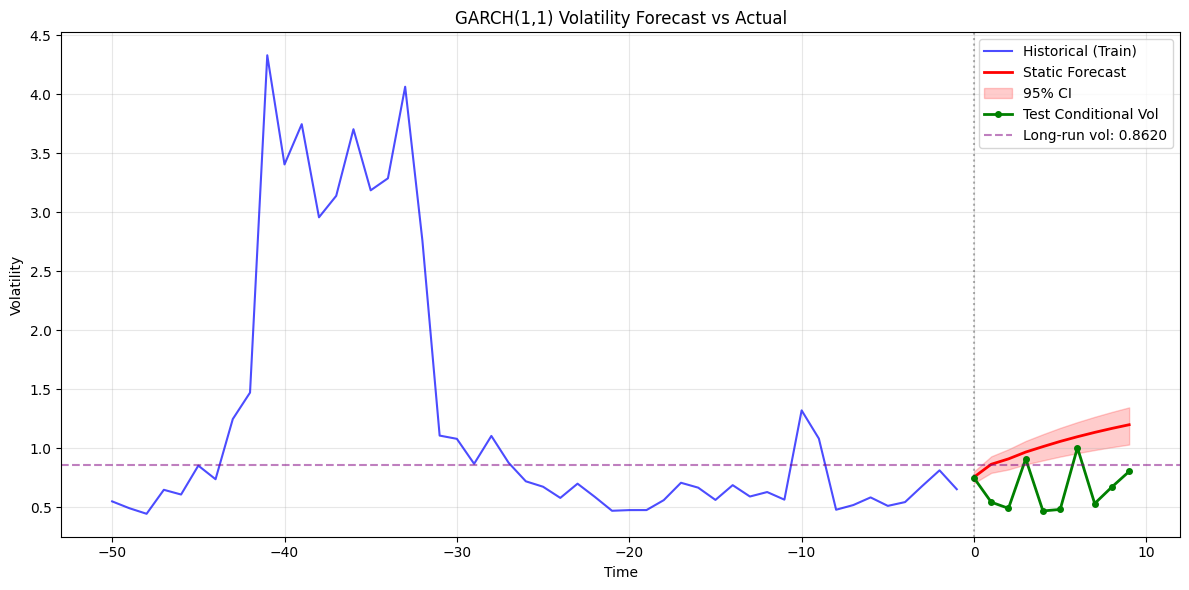


Forecast Accuracy:
MSE: 0.168493
MAE: 0.351291
95% CI Coverage: 30.0%


In [52]:
# Compute forecast with confidence intervals
horizon = 10
forecasts = res_fin.forecast(horizon=horizon, reindex=False)
variance_forecast = forecasts.variance.values[-1, :]
vol_forecast = np.sqrt(variance_forecast)

# Approximate 95% CI using standard error
# Standard error for variance forecast increases with horizon
std_errors = np.sqrt(2 * variance_forecast / len(df_train)) * np.sqrt(np.arange(1, horizon+1))
lower_var = np.maximum(variance_forecast - 1.96 * std_errors, 0)
upper_var = variance_forecast + 1.96 * std_errors

vol_lower = np.sqrt(lower_var)
vol_upper = np.sqrt(upper_var)

test_cond_vol = compute_test_conditional_volatility(res_fin, df_test['returns'].iloc[:horizon])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(-50, 0), res_fin.conditional_volatility[-50:], 'b-', alpha=0.7, label='Historical (Train)')
plt.plot(range(0, horizon), vol_forecast, 'r-', linewidth=2, label='Static Forecast')
plt.fill_between(range(0, horizon), vol_lower, vol_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(range(0, len(test_cond_vol)), test_cond_vol, 'g-', linewidth=2, 
         marker='o', markersize=4, label='Test Conditional Vol')
plt.axvline(x=0, color='black', linestyle=':', alpha=0.3)
plt.axhline(y=0.8620, color='purple', linestyle='--', alpha=0.5, label='Long-run vol: 0.8620')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title('GARCH(2,1) Volatility Forecast vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Accuracy metrics
mse = np.mean((vol_forecast - test_cond_vol)**2)
mae = np.mean(np.abs(vol_forecast - test_cond_vol))
coverage = np.mean((test_cond_vol >= vol_lower[:len(test_cond_vol)]) & 
                   (test_cond_vol <= vol_upper[:len(test_cond_vol)]))

print(f"\nForecast Accuracy:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"95% CI Coverage: {coverage*100:.1f}%")

The GARCH(2,1) model generated a static 10-period forecast, compared against actual conditional volatility computed recursively on the test set.

**Forecast Performance:**
- MSE: 0.1685
- MAE: 0.3513
- 95% CI Coverage: 30.0%

The forecast did pretty badly, similar to the Bitcoin model. The static forecast said that volatility would be heading upwards towards a long-run mean, but the test period showed volatility stuck in some sort of oscilations, bouncing between 0.5-1.0. This mismatch makes sense when you consider the way FX markets react to short-term shocks (91% response from $\alpha_1 + \alpha_2$).

The MAE of 0.35 (35 volatility points) is substantial, approximately 3x worse than Bitcoin's 0.13. More critically, the **30% CI coverage** indicates severe forecast uncertainty. 70% of actual values fell outside predicted bounds.

**Practical Implications:**
FX volatility's oscillating nature makes multi-step static forecasts unreliable. The high $\alpha$ coefficients (0.56 + 0.35) mean volatility responds sharply to immediate shocks, rendering static forecasts obsolete within 1-2 periods. 

**Recommendation:** Use **rolling one-step-ahead forecasts exclusively** for FX. The shock-driven volatility structure makes horizons beyond 2 periods highly inaccurate. Consider regime-switching models for the structural breaks evident around t=-40.